In [1]:
# Install BigQuery client
!pip install --quiet --upgrade google-cloud-bigquery

from google.cloud import bigquery
from google.colab import auth
import pandas as pd

# Step 1: Authenticate
auth.authenticate_user()

# Step 2: Replace with your OWN project ID
my_project_id = "wildfire-project-460511"  # 🔁 CHANGE THIS LINE!

# Step 3: Create BigQuery client under your project
client = bigquery.Client(project=my_project_id)

# Step 4: Query public dataset (no changes here)
query = """
SELECT *
FROM `bigquery-public-data.nasa_wildfire.past_week`
WHERE latitude IS NOT NULL
"""

# Step 5: Run the query
df = client.query(query).to_dataframe()
print("Loaded", len(df), "rows.")

# Optional: Save to CSV
df.to_csv("nasa_wildfire_full.csv", index=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.5/253.5 kB 4.3 MB/s eta 0:00:00
Loaded 572137 rows.


In [2]:
# Preview first few rows
df.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,confidence,version,bright_ti5,frp,daynight,acquisition_timestamp
0,62.49440,134.26344,367.0,0.5,0.66,2021-06-30,01:24:00,N,low,1.0NRT,303.1,36.6,D,2021-06-30 01:24:00+00:00
1,62.48775,134.24875,367.0,0.5,0.66,2021-06-30,01:24:00,N,low,1.0NRT,304.5,48.1,D,2021-06-30 01:24:00+00:00
2,62.48438,134.24130,367.0,0.5,0.66,2021-06-30,01:24:00,N,low,1.0NRT,304.0,31.2,D,2021-06-30 01:24:00+00:00
3,62.45597,134.17690,326.2,0.5,0.66,2021-06-30,01:24:00,N,low,1.0NRT,296.8,4.0,D,2021-06-30 01:24:00+00:00
4,62.49591,134.26375,367.0,0.5,0.66,2021-06-30,01:24:00,N,low,1.0NRT,298.3,43.2,D,2021-06-30 01:24:00+00:00


In [3]:
# Check column names and data types
df.info()

# Get a summary of numerical data
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572137 entries, 0 to 572136
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   latitude               572137 non-null  float64            
 1   longitude              572137 non-null  float64            
 2   bright_ti4             572137 non-null  float64            
 3   scan                   572137 non-null  float64            
 4   track                  572137 non-null  float64            
 5   acq_date               572137 non-null  dbdate             
 6   acq_time               572137 non-null  dbtime             
 7   satellite              572137 non-null  object             
 8   confidence             572137 non-null  object             
 9   version                572137 non-null  object             
 10  bright_ti5             572137 non-null  float64            
 11  frp                    572137 non-null 

,latitude,longitude,bright_ti4,scan,track,bright_ti5,frp
count,572137.000000,572137.000000,572137.000000,572137.000000,572137.000000,572137.000000,572137.000000
mean,12.424776,38.485989,335.422987,0.462314,0.484842,299.300651,11.690409
std,32.631144,65.040131,17.907851,0.089827,0.118170,10.479055,26.801362
min,-81.063740,-175.074280,208.000000,0.320000,0.360000,205.600000,0.000000
25%,-11.926250,17.819160,329.600000,0.390000,0.380000,292.300000,2.900000
50%,-7.074990,26.978080,337.000000,0.440000,0.450000,300.500000,5.500000
75%,51.370760,70.818780,346.000000,0.510000,0.570000,305.500000,10.800000
max,71.426790,179.651860,367.000000,0.800000,0.780000,380.000000,1643.000000


In [4]:
# Keep only the important columns for fire risk prediction
df = df[[
    'latitude',
    'longitude',
    'bright_ti4',
    'bright_ti5',
    'frp',
    'daynight',
    'acquisition_timestamp',
    'scan',         # optional
    'track',        # optional
    'satellite'     # optional
]]

df.head()

,latitude,longitude,bright_ti4,bright_ti5,frp,daynight,acquisition_timestamp,scan,track,satellite
0,62.49440,134.26344,367.0,303.1,36.6,D,2021-06-30 01:24:00+00:00,0.5,0.66,N
1,62.48775,134.24875,367.0,304.5,48.1,D,2021-06-30 01:24:00+00:00,0.5,0.66,N
2,62.48438,134.24130,367.0,304.0,31.2,D,2021-06-30 01:24:00+00:00,0.5,0.66,N
3,62.45597,134.17690,326.2,296.8,4.0,D,2021-06-30 01:24:00+00:00,0.5,0.66,N
4,62.49591,134.26375,367.0,298.3,43.2,D,2021-06-30 01:24:00+00:00,0.5,0.66,N


In [5]:
# Ensure timestamp is datetime
df['acquisition_timestamp'] = pd.to_datetime(df['acquisition_timestamp'])

# Extract useful time features
df['hour'] = df['acquisition_timestamp'].dt.hour
df['dayofweek'] = df['acquisition_timestamp'].dt.dayofweek  # Monday = 0, Sunday = 6
df['date'] = df['acquisition_timestamp'].dt.date  # Just the date (optional)

# Preview
df[['acquisition_timestamp', 'hour', 'dayofweek', 'date']].head()


,acquisition_timestamp,hour,dayofweek,date
0,2021-06-30 01:24:00+00:00,1,2,2021-06-30
1,2021-06-30 01:24:00+00:00,1,2,2021-06-30
2,2021-06-30 01:24:00+00:00,1,2,2021-06-30
3,2021-06-30 01:24:00+00:00,1,2,2021-06-30
4,2021-06-30 01:24:00+00:00,1,2,2021-06-30


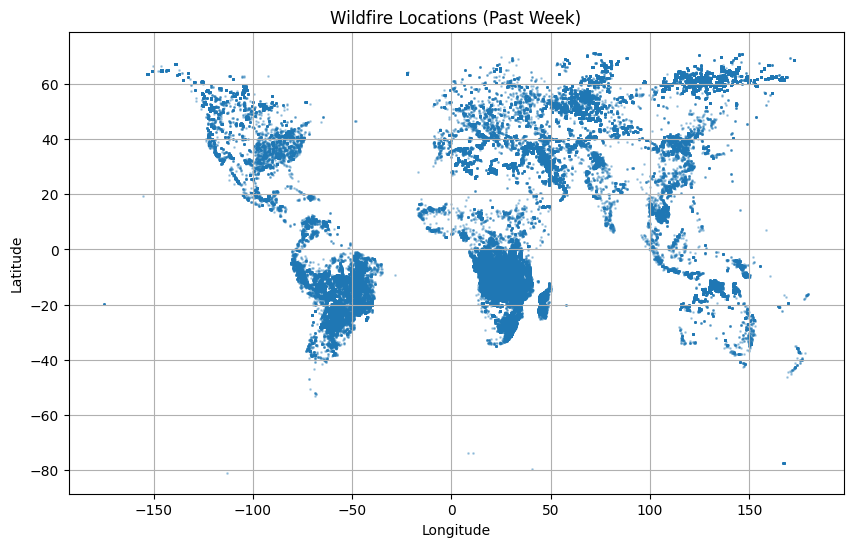

In [6]:
import matplotlib.pyplot as plt

# Basic scatter map of fire locations
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], s=1, alpha=0.3)
plt.title('Wildfire Locations (Past Week)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


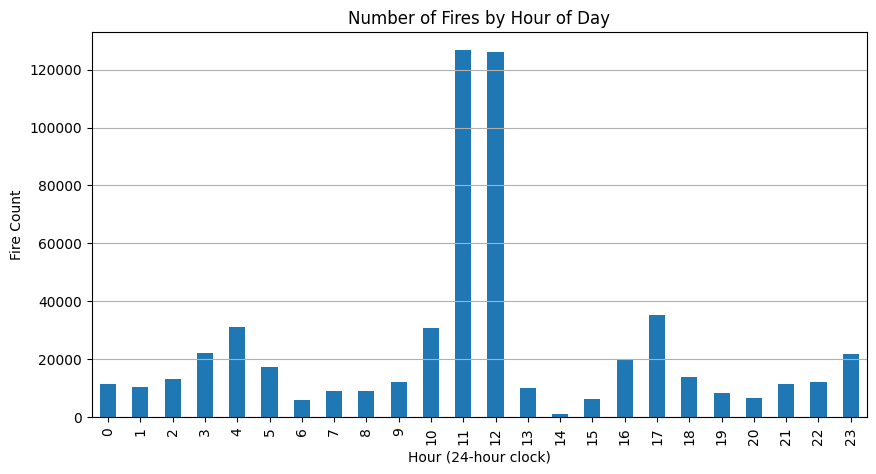

In [7]:
# Count of fires by hour
df['hour'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Number of Fires by Hour of Day')
plt.xlabel('Hour (24-hour clock)')
plt.ylabel('Fire Count')
plt.grid(axis='y')
plt.show()


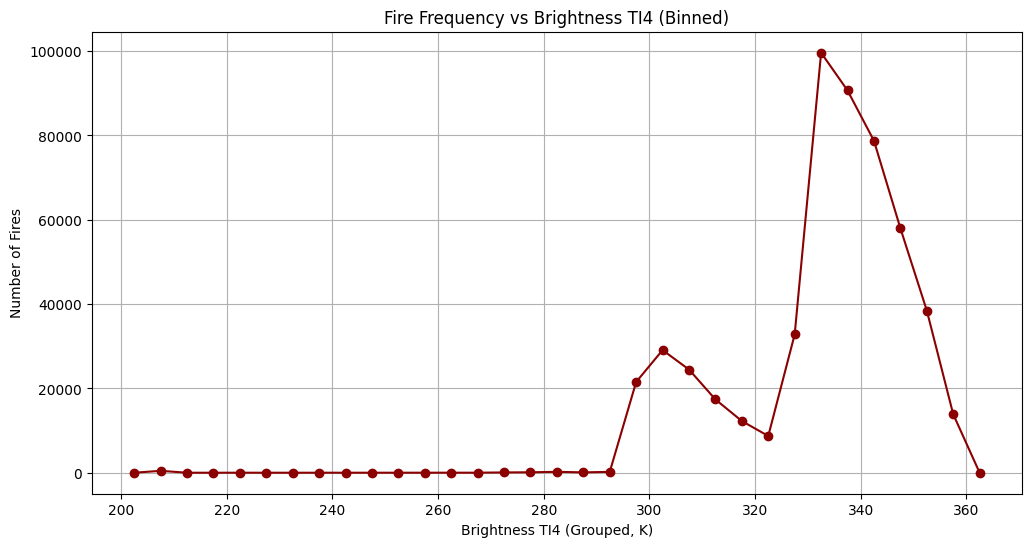

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Group brightness TI4 into bins (every 5K)
df['bright_ti4_bin'] = pd.cut(df['bright_ti4'], bins=range(200, 370, 5))

# Count how many fires fall into each bin
ti4_freq_binned = df['bright_ti4_bin'].value_counts().sort_index()

# Use bin midpoints for X-axis labels
ti4_bin_labels = [interval.mid for interval in ti4_freq_binned.index]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ti4_bin_labels, ti4_freq_binned.values, marker='o', color='darkred')
plt.title('Fire Frequency vs Brightness TI4 (Binned)')
plt.xlabel('Brightness TI4 (Grouped, K)')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.show()


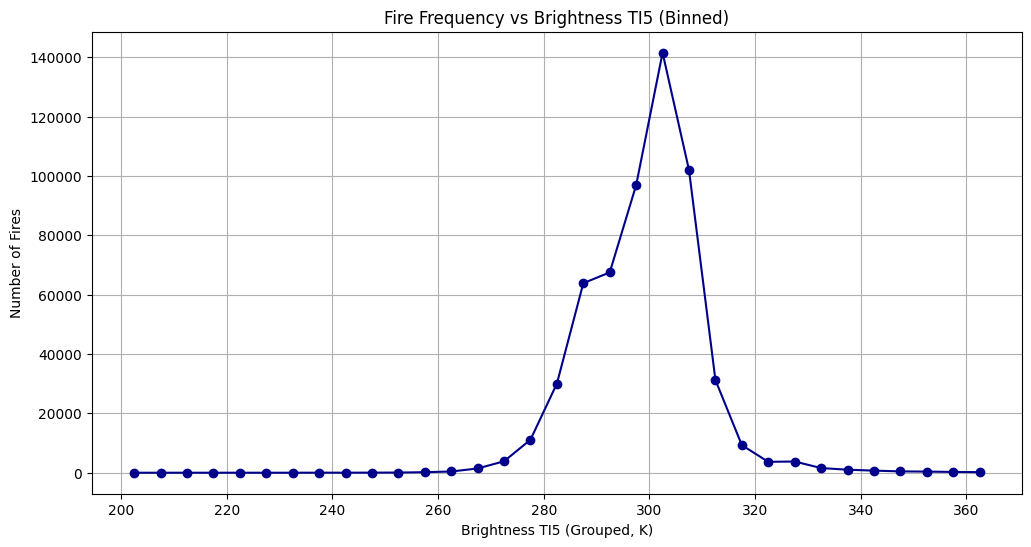

In [9]:
# Group brightness TI5 into bins (every 5K)
df['bright_ti5_bin'] = pd.cut(df['bright_ti5'], bins=range(200, 370, 5))

# Count how many fire records fall into each bin
ti5_freq_binned = df['bright_ti5_bin'].value_counts().sort_index()

# Use bin midpoints for X-axis labels
ti5_bin_labels = [interval.mid for interval in ti5_freq_binned.index]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ti5_bin_labels, ti5_freq_binned.values, marker='o', color='darkblue')
plt.title('Fire Frequency vs Brightness TI5 (Binned)')
plt.xlabel('Brightness TI5 (Grouped, K)')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.show()


In [10]:
# Recreate FRP bins and bin labels
df['frp_bin'] = pd.cut(df['frp'], bins=range(0, int(df['frp'].max()) + 10, 10))
frp_freq_binned = df['frp_bin'].value_counts().sort_index()
frp_bin_labels = [interval.mid for interval in frp_freq_binned.index]

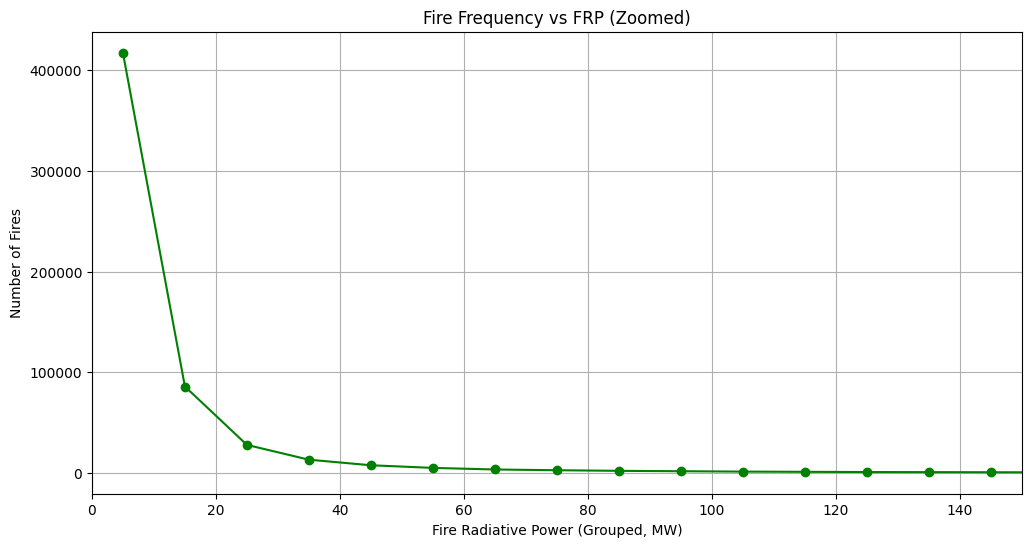

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(frp_bin_labels, frp_freq_binned.values, marker='o', color='green')
plt.title('Fire Frequency vs FRP (Zoomed)')
plt.xlabel('Fire Radiative Power (Grouped, MW)')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.xlim(0, 150)  # Zoom to focus on useful range
plt.show()

In [12]:
# Round latitude and longitude to 1 decimal to define grid zones
df['lat_grid'] = df['latitude'].round(1)
df['lon_grid'] = df['longitude'].round(1)

# Create a unique grid ID by combining both
df['grid_id'] = df['lat_grid'].astype(str) + "_" + df['lon_grid'].astype(str)

# Preview to verify
df[['latitude', 'longitude', 'lat_grid', 'lon_grid', 'grid_id']].head()

,latitude,longitude,lat_grid,lon_grid,grid_id
0,62.49440,134.26344,62.5,134.3,62.5_134.3
1,62.48775,134.24875,62.5,134.2,62.5_134.2
2,62.48438,134.24130,62.5,134.2,62.5_134.2
3,62.45597,134.17690,62.5,134.2,62.5_134.2
4,62.49591,134.26375,62.5,134.3,62.5_134.3


In [13]:
# Step 1: Round timestamp to the hour
df['acq_hour'] = df['acquisition_timestamp'].dt.floor('h')  # lowercase 'h' to avoid warning

# Step 2: Group by grid and hour, calculate summary features
grouped = df.groupby(['grid_id', 'acq_hour']).agg(
    fire_count=('frp', 'count'),
    avg_bright_ti4=('bright_ti4', 'mean'),
    avg_frp=('frp', 'mean')
).reset_index()

# Step 3: Create history-based features (previous hour’s data)
grouped['fire_count_last_1hr'] = grouped.groupby('grid_id')['fire_count'].shift(1)
grouped['avg_bright_ti4_last_1hr'] = grouped.groupby('grid_id')['avg_bright_ti4'].shift(1)
grouped['avg_frp_last_1hr'] = grouped.groupby('grid_id')['avg_frp'].shift(1)

# Step 4: Drop rows where there's no previous hour (NaNs)
grouped_clean = grouped.dropna(subset=[
    'fire_count_last_1hr',
    'avg_bright_ti4_last_1hr',
    'avg_frp_last_1hr'
])

# Step 5: Preview the clean result
pd.set_option('display.max_rows', 100)
grouped_clean = grouped_clean.reset_index(drop=True)
grouped_clean.head(6)

,grid_id,acq_hour,fire_count,avg_bright_ti4,avg_frp,fire_count_last_1hr,avg_bright_ti4_last_1hr,avg_frp_last_1hr
0,-0.0_11.9,2021-07-04 00:00:00+00:00,1,301.70,0.8,1.0,328.90,2.300
1,-0.0_24.1,2021-07-01 12:00:00+00:00,1,338.50,6.4,1.0,327.30,6.500
2,-0.1_-77.7,2021-07-03 06:00:00+00:00,2,322.50,4.6,4.0,320.65,5.775
3,-0.1_-77.7,2021-07-05 07:00:00+00:00,2,316.45,3.7,2.0,322.50,4.600
4,-0.1_-77.7,2021-07-07 06:00:00+00:00,5,317.84,3.3,2.0,316.45,3.700
5,-0.1_12.0,2021-07-01 12:00:00+00:00,1,330.60,2.4,1.0,298.50,0.600


🔥 fire_next value counts:
 fire_next
1    71668
0    30090
Name: count, dtype: int64

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.34      0.23      0.28      6083
           1       0.71      0.81      0.76     14269

    accuracy                           0.64     20352
   macro avg       0.53      0.52      0.52     20352
weighted avg       0.60      0.64      0.61     20352



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


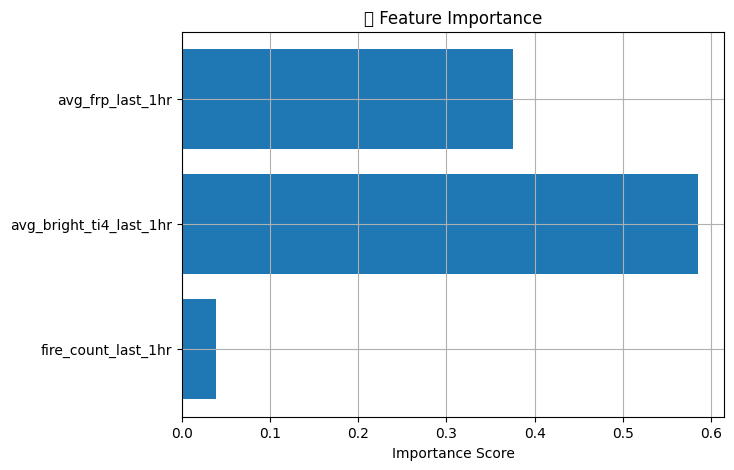

In [14]:
# Sort and shift fire_count to create fire_next (future fire indicator)
grouped = grouped.sort_values(by=['grid_id', 'acq_hour'])
grouped['fire_next'] = grouped.groupby('grid_id')['fire_count'].shift(-1)
grouped['fire_next'] = (grouped['fire_next'] > 0).astype(int)

# Drop rows with missing history-based features
grouped_clean = grouped.dropna(subset=[
    'fire_count_last_1hr', 'avg_bright_ti4_last_1hr', 'avg_frp_last_1hr', 'fire_next'
])

# Define features and target
features = ['fire_count_last_1hr', 'avg_bright_ti4_last_1hr', 'avg_frp_last_1hr']
X = grouped_clean[features]
y = grouped_clean['fire_next']

# Check if we now have 0 and 1 both
print("🔥 fire_next value counts:\n", y.value_counts())

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prediction
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Feature Importance
import matplotlib.pyplot as plt
importances = model.feature_importances_
plt.figure(figsize=(7, 5))
plt.barh(features, importances)
plt.xlabel("Importance Score")
plt.title("🔥 Feature Importance")
plt.grid(True)
plt.show()

In [15]:
# Step 1: Predict for entire cleaned data (this simulates live future prediction)
grouped_clean['predicted_fire'] = model.predict(X)

# Step 2: Calculate fire risk per grid
fire_risk = grouped_clean.groupby('grid_id')['predicted_fire'].sum().reset_index()
fire_risk.columns = ['grid_id', 'predicted_fire_count']

# Split grid_id into lat/lon
fire_risk[['lat', 'lon']] = fire_risk['grid_id'].str.split('_', expand=True).astype(float)

# Preview
fire_risk.head()


<ipython-input-15-5c2c0fbb022f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_clean['predicted_fire'] = model.predict(X)


,grid_id,predicted_fire_count,lat,lon
0,-0.0_11.9,1,-0.0,11.9
1,-0.0_24.1,1,-0.0,24.1
2,-0.1_-77.7,2,-0.1,-77.7
3,-0.1_12.0,1,-0.1,12.0
4,-0.1_15.5,0,-0.1,15.5


In [16]:
from google.colab import files

uploaded = files.upload()


Saving ne_110m_admin_0_countries.dbf to ne_110m_admin_0_countries.dbf
Saving ne_110m_admin_0_countries.prj to ne_110m_admin_0_countries.prj
Saving ne_110m_admin_0_countries.shp to ne_110m_admin_0_countries.shp
Saving ne_110m_admin_0_countries.shx to ne_110m_admin_0_countries.shx


In [17]:
!pip install geopandas

In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the shapefile (you may need to adjust the filename if it's different)
world = gpd.read_file('ne_110m_admin_0_countries.shp')


In [19]:
from shapely.geometry import Point

fire_risk['geometry'] = fire_risk.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
fire_gdf = gpd.GeoDataFrame(fire_risk, geometry='geometry', crs='EPSG:4326')


In [20]:
# Filter by lat/lon range to focus on wildfire-prone regions
fire_risk_filtered = fire_risk[
    (fire_risk['lat'] > -45) & (fire_risk['lat'] < 40) &    # Tropical to subtropical zones
    (fire_risk['predicted_fire_count'] >= 5)               # Only show areas with 5+ predicted fires
]


<ipython-input-21-87f4e5d6b2b5>:18: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


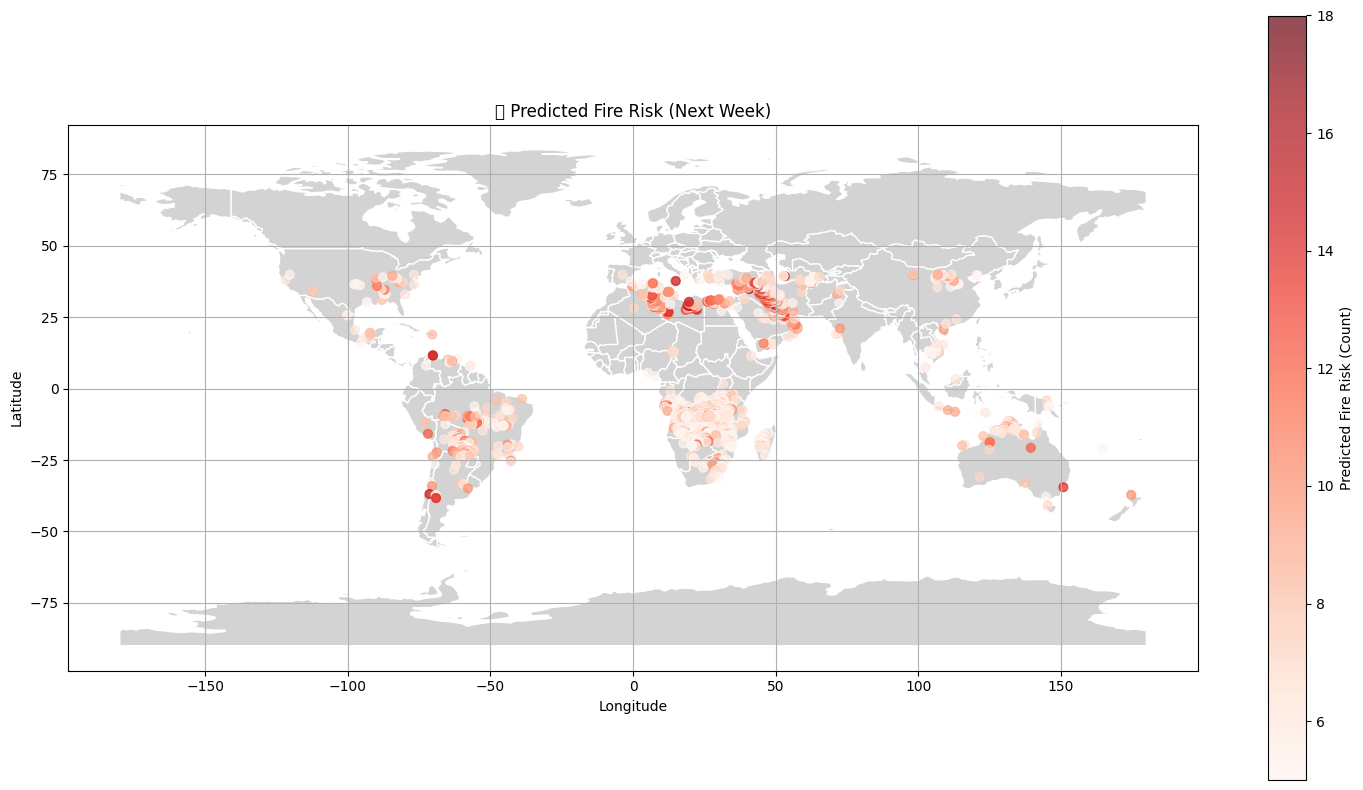

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))
world.plot(ax=ax, color='lightgray', edgecolor='white')

scatter = ax.scatter(
    fire_risk_filtered['lon'],
    fire_risk_filtered['lat'],
    c=fire_risk_filtered['predicted_fire_count'],
    cmap='Reds',
    alpha=0.7,
    s=40
)

plt.colorbar(scatter, ax=ax, label="Predicted Fire Risk (Count)")
plt.title("🔥 Predicted Fire Risk (Next Week)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()
